In [1]:
import numpy as np

1. Load EEG Segment

In [50]:
import pandas as pd

train_df = pd.read_parquet("../data/train/segments.parquet")
test_df = pd.read_parquet("../data/test/segments.parquet")
distances_df = pd.read_csv("../data/distances_3d.csv", index_col=0)

print(train_df.head())
print(distances_df.head())


                            label  start_time  end_time       date  \
patient  session   segment                                           
pqejgcff s001_t000 0            1         0.0      12.0 2003-01-01   
                   1            1        12.0      24.0 2003-01-01   
                   2            1        24.0      36.0 2003-01-01   
                   3            1        36.0      48.0 2003-01-01   
                   4            1        48.0      60.0 2003-01-01   

                            sampling_rate                        signals_path  
patient  session   segment                                                     
pqejgcff s001_t000 0                  250  signals/pqejgcff_s001_t000.parquet  
                   1                  250  signals/pqejgcff_s001_t000.parquet  
                   2                  250  signals/pqejgcff_s001_t000.parquet  
                   3                  250  signals/pqejgcff_s001_t000.parquet  
                   4         

In [51]:
import pandas as pd

# Example: load one segment's signals
segment_row = train_df.iloc[100]
full_signals = pd.read_parquet(f"../data/train/{segment_row['signals_path']}")

# ✅ Extraire uniquement les 12 secondes correspondant à ce segment
start = int(segment_row["start_time"] * segment_row["sampling_rate"])  # 12.0 * 250 = 3000
end = int(segment_row["end_time"] * segment_row["sampling_rate"])

signals = full_signals.iloc[start:end]  # ✅ Maintenant ça fait 3000 lignes

# signals is likely channels x time (double check!)
print(signals.shape)
print(signals.head())


(3000, 19)
         FP1        FP2         F3         F4        C3        C4        P3  \
0  17.089853  15.563973  17.700204  26.245131  1.525880 -1.525880 -8.544926   
1  17.041667  11.243324  23.145186  20.398602  7.276037 -3.099945 -5.846529   
2  17.925071  17.009543  24.944118  26.775173  4.192154 -4.047597 -5.878652   
3  15.290921  18.037504  17.732328  18.037504  2.473531 -5.766219 -5.155867   
4  17.025605  20.382540  21.603244  19.467013  9.701382 -6.472942 -1.895303   

          P4         O1         O2         F7         F8         T3  \
0 -19.226084 -41.809104  15.563973  19.226084  -3.662111  -8.850102   
1 -20.189798 -38.500354  15.820963  21.924482 -16.527686 -11.034519   
2 -22.358153 -39.448006  12.431904  18.840599  -7.709708 -18.085690   
3 -22.856072 -42.692508  11.933985  35.127357  -1.798932 -10.954210   
4 -22.647267 -38.821592   9.091031  37.167217  -5.862590 -30.276666   

          T4         T5        T6         FZ         CZ        PZ  
0 -21.972668  20.75

Extrait du DataFrame `signals`, qui contient les signaux EEG bruts pour un segment donné.

- **(328000, 19)** : Le DataFrame a 328 000 lignes (échantillons temporels) et 19 colonnes (électrodes).
- **Colonnes (FP1, FP2, F3, ...)** : Chaque colonne représente une électrode placée sur le cuir chevelu selon le système international 10-20.
- **Lignes** : Chaque ligne correspond à une mesure à un instant donné (par exemple, à une fréquence d'échantillonnage de 250 Hz, chaque ligne est espacée de 4 ms).
- **Valeurs** : Les valeurs sont les amplitudes du signal EEG mesurées à chaque électrode, à chaque instant.

En résumé, ce DataFrame représente l'évolution temporelle des signaux EEG enregistrés simultanément sur 19 électrodes.

In [52]:
print(distances_df)

       to  distance
from               
FP1   FP1  0.000000
FP1   FP2  0.618000
FP1    F3  0.618969
FP1    F4  1.030322
FP1    C3  1.250226
...   ...       ...
PZ     T5  1.081066
PZ     T6  1.081066
PZ     FZ  1.414200
PZ     CZ  0.765363
PZ     PZ  0.000000

[361 rows x 2 columns]


In [53]:
from sklearn.manifold import MDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

distances_df = distances_df.reset_index()


# Tu l'as déjà : distances_df avec colonnes "from", "to", "distance"
# (réindexer si nécessaire)
electrodes = sorted(set(distances_df['from']) | set(distances_df['to']))
dist_mat = (
    distances_df
    .pivot(index="from", columns="to", values="distance")
    .reindex(index=electrodes, columns=electrodes)
    .fillna(np.inf)
)

# Remplir la diagonale à 0
np.fill_diagonal(dist_mat.values, 0)
dist_mat


to,C3,C4,CZ,F3,F4,F7,F8,FP1,FP2,FZ,O1,O2,P3,P4,PZ,T3,T4,T5,T6
from,,,,,,,,,,,,,,,,,,,
C3,0.000000,1.414200,0.765363,0.721208,1.439670,0.925139,1.773149,1.250226,1.561102,0.999990,1.250226,1.561102,0.721208,1.439670,0.999990,0.765363,1.847750,0.925139,1.773149
C4,1.414200,0.000000,0.765363,1.439670,0.721208,1.773149,0.925139,1.561102,1.250226,0.999990,1.561102,1.250226,1.439670,0.721208,0.999990,1.847750,0.765363,1.773149,0.925139
CZ,0.765363,0.765363,0.000000,1.002486,1.002486,1.414210,1.414210,1.414239,1.414239,0.765363,1.414239,1.414239,1.002486,1.002486,0.765363,1.414214,1.414214,1.414210,1.414210
F3,0.721208,1.439670,1.002486,0.000000,1.097800,0.567624,1.448599,0.618969,1.030322,0.588623,1.714216,1.901836,1.343400,1.734903,1.498770,0.949831,1.760051,1.378948,1.917743
F4,1.439670,0.721208,1.002486,1.097800,0.000000,1.448599,0.567624,1.030322,0.618969,0.588623,1.901836,1.714216,1.734903,1.343400,1.498770,1.760051,0.949831,1.917743,1.378948
F7,0.925139,1.773149,1.414210,0.567624,1.448599,0.000000,1.618000,0.618051,1.175547,1.081066,1.618089,1.902140,1.378948,1.917743,1.682628,0.618053,1.902101,1.175600,1.999990
F8,1.773149,0.925139,1.414210,1.448599,0.567624,1.618000,0.000000,1.175547,0.618051,1.081066,1.902140,1.618089,1.917743,1.378948,1.682628,1.902101,0.618053,1.999990,1.175600
FP1,1.250226,1.561102,1.414239,0.618969,1.030322,0.618051,1.175547,0.000000,0.618000,0.809325,1.902200,2.000072,1.714216,1.901836,1.828961,1.175616,1.618046,1.618089,1.902140
FP2,1.561102,1.250226,1.414239,1.030322,0.618969,1.175547,0.618051,0.618000,0.000000,0.809325,2.000072,1.902200,1.901836,1.714216,1.828961,1.618046,1.175616,1.902140,1.618089


In [54]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions_2d = mds.fit_transform(dist_mat.values)

# Associer les positions aux noms d'électrodes
pos_dict = {electrode: positions_2d[i] for i, electrode in enumerate(electrodes)}
pos_dict


{'C3': array([-0.54714618,  0.44629583]),
 'C4': array([ 0.53222914, -0.44723388]),
 'CZ': array([-0.01869549, -0.00196644]),
 'F3': array([0.01274023, 0.86706647]),
 'F4': array([0.84624436, 0.16915277]),
 'F7': array([-0.27257231,  1.05746297]),
 'F8': array([ 1.09000173, -0.08330917]),
 'FP1': array([0.41106377, 1.0178474 ]),
 'FP2': array([0.92878688, 0.5843577 ]),
 'FZ': array([0.44741726, 0.53901195]),
 'O1': array([-0.92893557, -0.58980595]),
 'O2': array([-0.395064  , -1.02582048]),
 'P3': array([-0.85494907, -0.17339447]),
 'P4': array([-0.0106752 , -0.86821959]),
 'PZ': array([-0.45669924, -0.54684095]),
 'T3': array([-0.83946093,  0.71099448]),
 'T4': array([ 0.85065895, -0.69324527]),
 'T5': array([-1.09192797,  0.09025441]),
 'T6': array([ 0.29698364, -1.05260779])}

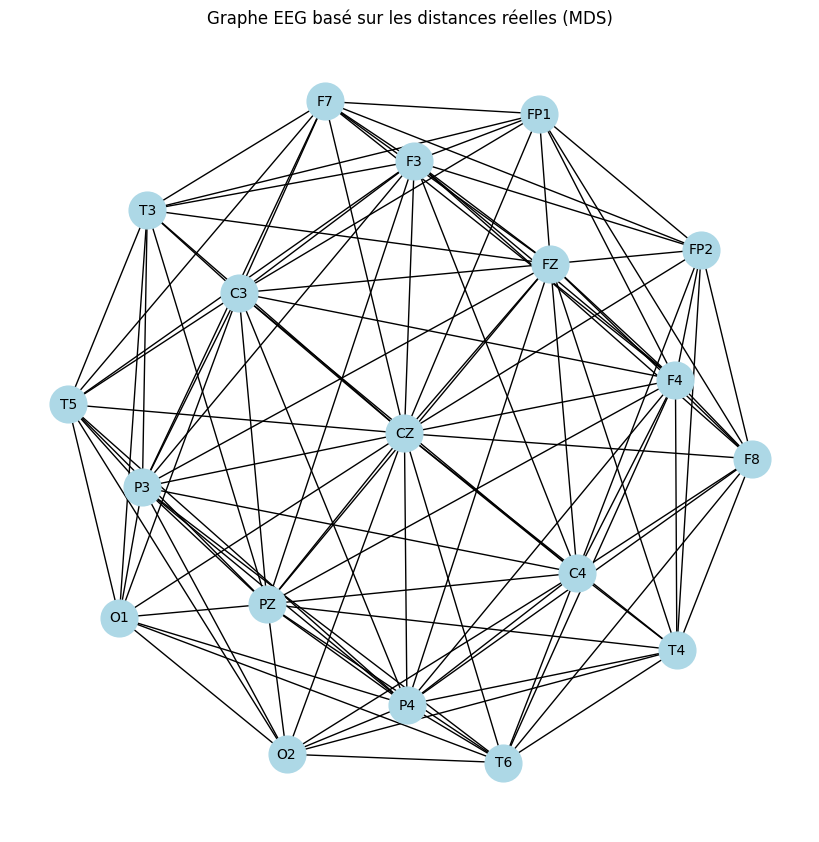

In [55]:
# Construire le graphe comme tu le faisais
adj_matrix = np.zeros((len(electrodes), len(electrodes)))
for i, u in enumerate(electrodes):
    for j, v in enumerate(electrodes):
        if u == v: continue
        d = dist_mat.loc[u, v]
        if d < 1.5:
            adj_matrix[i, j] = 1/(1+d)

G = nx.from_numpy_array(adj_matrix)
G = nx.relabel_nodes(G, dict(enumerate(electrodes)))  # remettre les noms

# Dessin avec positions réalistes (apprises)
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos_dict, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
plt.title("Graphe EEG basé sur les distances réelles (MDS)")
plt.axis("equal")
plt.show()


In [56]:
# Assign EEG signals to each node in the graph as node attributes
for electrode in electrodes:
    G.nodes[electrode]['eeg'] = signals[electrode].values


# Example: access the EEG signal for a specific electrode
example_electrode = 'FZ'
print(f"EEG signal for electrode {example_electrode}:")
print(G.nodes[example_electrode]['eeg'][:20])  # Print first 20 samples of the signal
print(f"Signal length: {len(G.nodes[example_electrode]['eeg'])}")
print(f"Signal shape: {G.nodes[example_electrode]['eeg'].shape}")


EEG signal for electrode FZ:
[-28.38136235 -28.42954802 -30.90307932 -32.31652577 -29.36113773
 -28.67047639 -30.69427473 -31.70617389 -29.39326151 -28.23680532
 -28.25286721 -30.40516068 -29.56994232 -28.89534288 -31.20825526
 -30.3730369  -28.49379559 -27.93162938 -28.44560991 -30.32485122]
Signal length: 3000
Signal shape: (3000,)


In [57]:
import torch
from torch_geometric.data import Data

# Prepare node features: stack EEG signals for all electrodes (shape: num_nodes x num_timesteps)
# Here, each node feature is the EEG time series for that electrode
node_features = []
for electrode in electrodes:
    node_features.append(G.nodes[electrode]['eeg'])
x = torch.tensor(np.stack(node_features, axis=0), dtype=torch.float)  # shape: [num_nodes, num_timesteps]

# Prepare edge index from the graph (only keep edges with weight > 0)
edge_index = []
edge_attr = []
for u, v, d in G.edges(data=True):
    edge_index.append([electrodes.index(u), electrodes.index(v)])
    edge_attr.append([d['weight']])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape: [2, num_edges]
edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # shape: [num_edges, 1]

# Optionally, add label if available
if 'label' in segment_row:
    y = torch.tensor([segment_row['label']], dtype=torch.long)
else:
    y = None

# Build the PyG Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Preview the Data object
print(data)
# Example: access the EEG signal for a specific electrode
print(f"Node features shape: {data.x.shape}")  # Should be [num_nodes, num_timesteps]
print(f"Ex : EEG signal for electrode {electrodes[0]}: {data.x[0][:20]}")  # Print first 20 samples of the first electrode's signal
print("\n")
print(f"Edge index shape: {data.edge_index.shape}")  # Should be [2, num_edges]
print(f"Ex : Edge 4: {data.edge_index[:, 3]}")  # Print first edge index
print("\n")
print(f"Edge attributes shape: {data.edge_attr.shape}")  # Should be [num_edges, 1]
print(f"Ex : Edge attribute for edge 4: {data.edge_attr[3]}")  # Print first edge attribute


Data(x=[19, 3000], edge_index=[2, 110], edge_attr=[110, 1], y=[1])
Node features shape: torch.Size([19, 3000])
Ex : EEG signal for electrode C3: tensor([ 1.5259,  7.2760,  4.1922,  2.4735,  9.7014,  5.5092,  0.7388,  6.4408,
         6.3123,  2.8911,  4.4010,  5.9108,  9.4926, 12.6086, 13.6526,  9.6050,
        11.4843, 11.7412,  7.2600,  7.8221])


Edge index shape: torch.Size([2, 110])
Ex : Edge 4: tensor([0, 4])


Edge attributes shape: torch.Size([110, 1])
Ex : Edge attribute for edge 4: tensor([0.4099])


Ce bloc de code prépare les données EEG sous forme de graphe pour l'apprentissage profond avec PyTorch Geometric (PyG) :

- **Node features (`x`)** : On empile les signaux EEG de chaque électrode (chaque nœud du graphe) pour obtenir une matrice de forme `[nombre d'électrodes, nombre d'échantillons temporels]`. Chaque ligne correspond au signal d'une électrode.
- **Edge index (`edge_index`)** : On extrait la liste des connexions (arêtes) du graphe EEG, en codant chaque arête par les indices des électrodes connectées.
- **Edge attributes (`edge_attr`)** : Chaque arête reçoit un poids (ici, l'inverse de la distance entre électrodes).
- **Label (`y`)** : Si le segment EEG possède une étiquette (par exemple, crise ou non), elle est ajoutée.
- **Objet `Data`** : Toutes ces informations sont regroupées dans un objet `Data` de PyG, qui sera utilisé comme entrée pour un modèle de graphes (GNN).

En résumé, ce code convertit un segment EEG en un graphe prêt à être traité par un réseau de neurones à graphes.

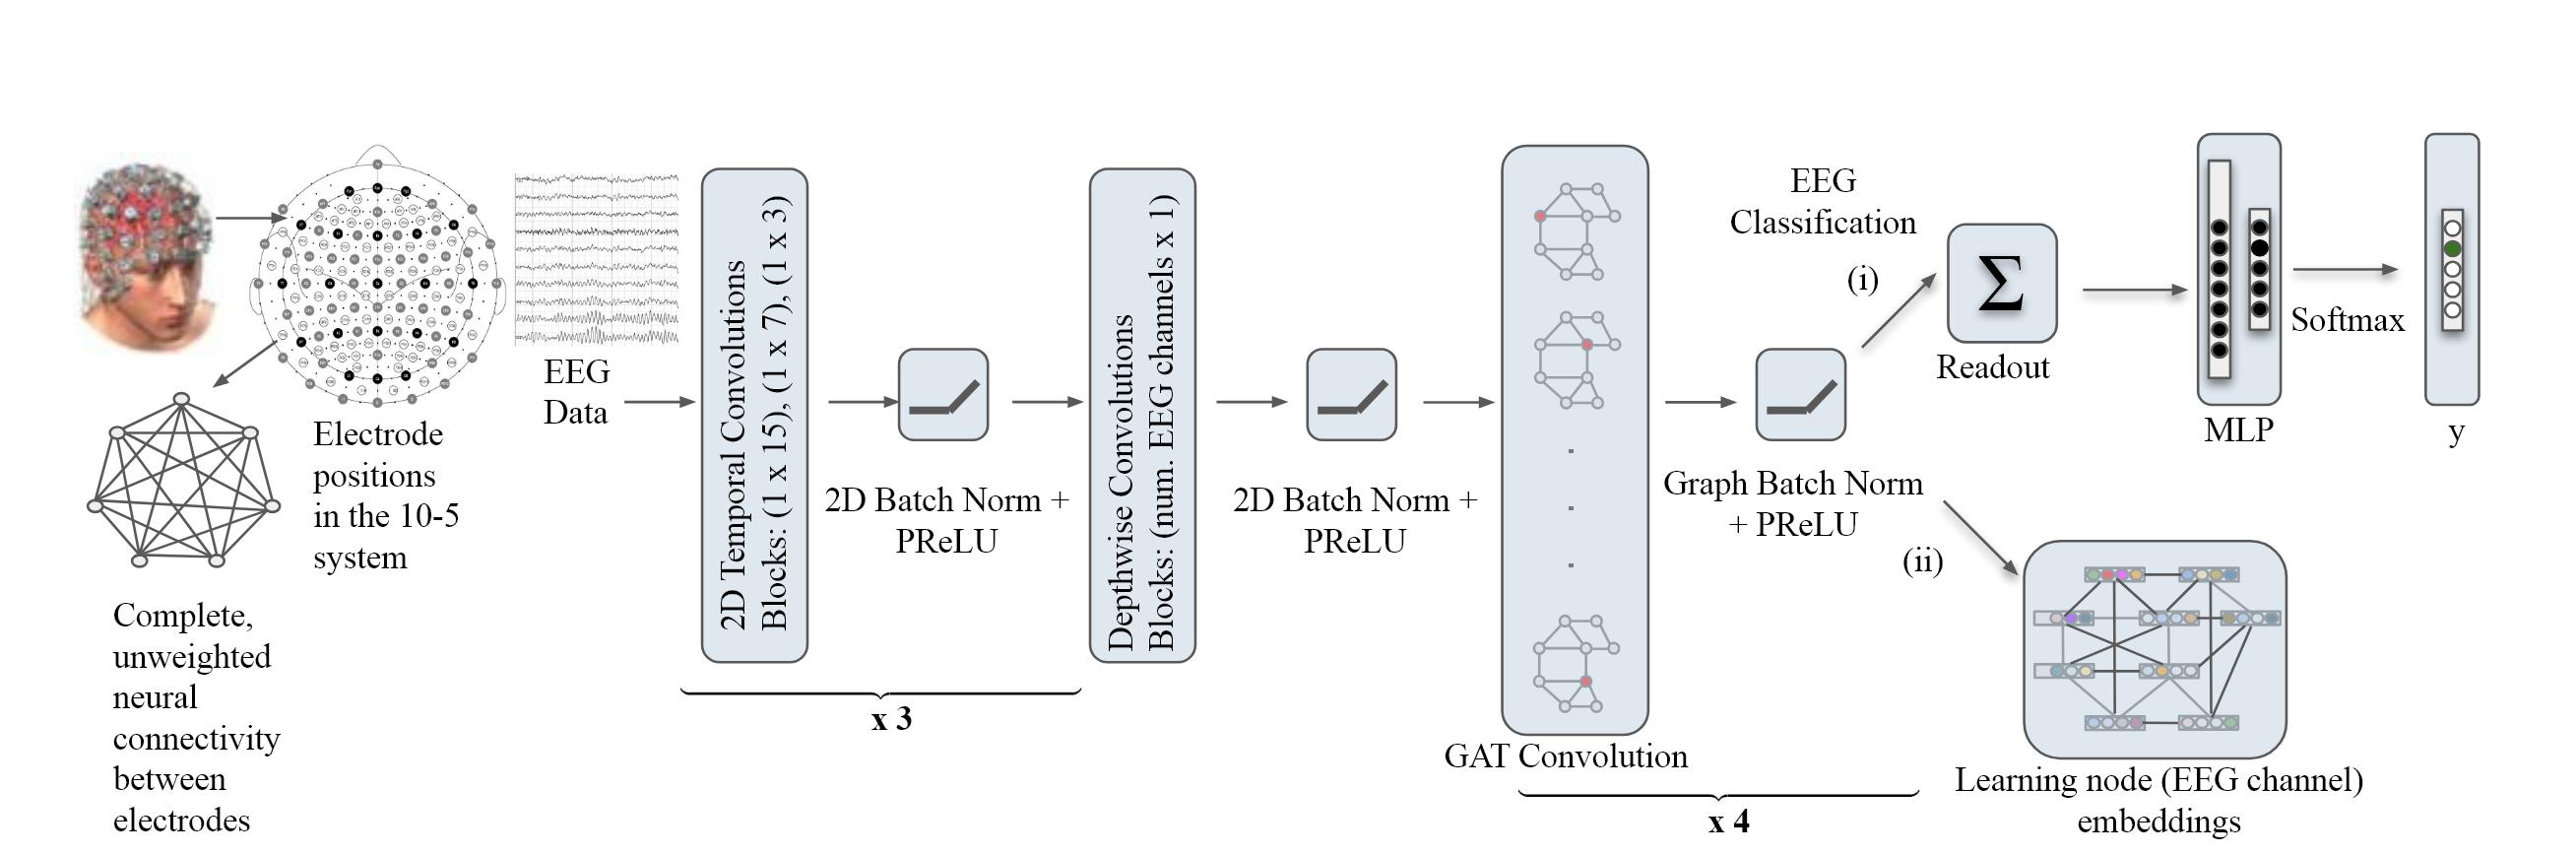

In [104]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm

class EEGGAT(nn.Module):
    def __init__(self, in_channels, gat_out_channels=32, heads=4, time_len=3000):
        super(EEGGAT, self).__init__()

        # === 1. Temporal convolutions ===
        self.temporal_conv1 = nn.Conv2d(1, 30, kernel_size=(1, 15), padding=(0, 7))
        self.temporal_conv2 = nn.Conv2d(30, 60, kernel_size=(1, 7), padding=(0, 3))
        self.temporal_conv3 = nn.Conv2d(60, 90, kernel_size=(1, 3), padding=(0, 1))

        self.bn1 = nn.BatchNorm2d(30)
        self.bn2 = nn.BatchNorm2d(60)
        self.bn3 = nn.BatchNorm2d(90)

        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.prelu_depth = nn.PReLU()

        # === 2. Depthwise conv ===
        self.depthwise = nn.Conv2d(90, 90, kernel_size=(1, 1), groups=90)
        self.depth_bn = nn.BatchNorm2d(90)

        # === 3. GAT Blocks ×4 ===
        self.gat1 = GATConv(time_len, gat_out_channels, heads=heads, concat=True, edge_dim=1)
        self.gat2 = GATConv(gat_out_channels * heads, gat_out_channels, heads=heads, concat=True, edge_dim=1)
        self.gat3 = GATConv(gat_out_channels * heads, gat_out_channels, heads=heads, concat=True, edge_dim=1)
        self.gat4 = GATConv(gat_out_channels * heads, gat_out_channels, heads=heads, concat=True, edge_dim=1)

        self.bn_g1 = BatchNorm(gat_out_channels * heads)
        self.bn_g2 = BatchNorm(gat_out_channels * heads)
        self.bn_g3 = BatchNorm(gat_out_channels * heads)
        self.bn_g4 = BatchNorm(gat_out_channels * heads)

        self.prelu_g1 = nn.PReLU()
        self.prelu_g2 = nn.PReLU()
        self.prelu_g3 = nn.PReLU()
        self.prelu_g4 = nn.PReLU()

        # === 4. Classifier ===
        self.classifier = nn.Sequential(
            nn.Linear(gat_out_channels * heads, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # x: [nodes, time]

        # === Temporal convs ===
        x = x.unsqueeze(1).unsqueeze(1)  # [nodes, 1, 1, time]
        x = self.prelu1(self.bn1(self.temporal_conv1(x)))
        x = self.prelu2(self.bn2(self.temporal_conv2(x)))
        x = self.prelu3(self.bn3(self.temporal_conv3(x)))
        x = self.prelu_depth(self.depth_bn(self.depthwise(x)))  # [nodes, 90, 1, T]
        x = x.squeeze(2)  # [nodes, 90, time]
        x = x.mean(dim=1)  # [nodes, time]

        # === GAT blocks ===
        x = self.prelu_g1(self.bn_g1(self.gat1(x, edge_index, data.edge_attr)))
        x = self.prelu_g2(self.bn_g2(self.gat2(x, edge_index, data.edge_attr))) + x
        x = self.prelu_g3(self.bn_g3(self.gat3(x, edge_index, data.edge_attr))) + x
        x = self.prelu_g4(self.bn_g4(self.gat4(x, edge_index, data.edge_attr))) + x

        # === Readout ===
        x = global_mean_pool(x, batch)  # [batch, features]

        return self.classifier(x)  # [batch, 2]


In [105]:
from torch_geometric.data import Batch

batch = Batch.from_data_list([data])  # batch de 1 seul graphe


In [106]:
model = EEGGAT(in_channels=19, time_len=data.x.shape[1])  # 19 électrodes, 3000 samples/time_len
output = model(batch)

print("Output shape :", output.shape)  # [1, 2]
print("Logits :", output)


Output shape : torch.Size([1, 2])
Logits : tensor([[ 0.2727, -0.0700]], grad_fn=<AddmmBackward0>)


In [107]:
from torch_geometric.data import Data
from tqdm import tqdm

def augment_eeg_segment(segment):
    # Exemples simples d'augmentations :
    if np.random.rand() < 0.5:
        segment += np.random.normal(0, 0.5, size=segment.shape)  # bruit gaussien

    if np.random.rand() < 0.5:
        shift = np.random.randint(1, 50)
        segment = segment.shift(shift, fill_value=0)

    return segment



def build_graph_dataset(df, electrodes, adj_matrix, base_path="../data/train/"):
    
    dataset = []
    edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
    loaded_files = {}

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = base_path + row["signals_path"]

        if path not in loaded_files:
            loaded_files[path] = pd.read_parquet(path)

        full_signals = loaded_files[path]
        start = int(row["start_time"] * row["sampling_rate"])
        end = int(row["end_time"] * row["sampling_rate"])

        segment = full_signals.iloc[start:end]
        if int(row["label"]) == 1:
            segment = augment_eeg_segment(segment)
            
        if segment.shape[0] != 3000:
            continue  # skip corrupted segments

        try:
            x = torch.tensor(segment[electrodes].values.T, dtype=torch.float32)  # [19, 3000]
        except Exception as e:
            continue  # skip if electrode mismatch

        y = torch.tensor([int(row["label"])], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        dataset.append(data)

    return dataset


Ce code définit la fonction `build_graph_dataset`, qui convertit un DataFrame de segments EEG en une liste d’objets `Data` utilisables par PyTorch Geometric. Voici le détail étape par étape :

- **Chargement des dépendances** :  
    - `Data` (PyG) pour représenter un graphe.
    - `tqdm` pour afficher une barre de progression.

- **Arguments** :  
    - `df` : DataFrame contenant les segments EEG (chemin, temps, label…).
    - `electrodes` : liste des noms d’électrodes à extraire.
    - `adj_matrix` : matrice d’adjacence du graphe EEG (connexions entre électrodes).
    - `base_path` : dossier racine des fichiers de signaux.

- **Construction de la liste `dataset`** :  
    - Calcule `edge_index` à partir de la matrice d’adjacence (indices des connexions entre électrodes).
    - Utilise un cache `loaded_files` pour éviter de relire plusieurs fois le même fichier de signaux.

- **Boucle sur chaque segment EEG** :  
    - Calcule le chemin du fichier de signaux.
    - Charge le fichier si besoin.
    - Extrait le segment temporel correspondant (start/end).
    - Ignore les segments corrompus (pas 3000 échantillons).
    - Tente d’extraire les signaux des électrodes demandées et transpose pour obtenir `[19, 3000]`.
    - Ignore si erreur (électrodes manquantes).
    - Crée le label `y` à partir de la colonne `label`.
    - Crée un objet `Data` (PyG) avec :  
        - `x` : signaux EEG (features des nœuds)
        - `edge_index` : structure du graphe
        - `y` : label du segment
    - Ajoute à la liste `dataset`.

- **Retourne** :  
    - Une liste de graphes EEG prêts pour l’entraînement d’un GNN.

In [108]:
dataset = build_graph_dataset(train_df, electrodes, adj_matrix)
print(f"{len(dataset)} segments chargés.")


100%|██████████| 12993/12993 [00:18<00:00, 691.71it/s]

12993 segments chargés.


In [109]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.1, random_state=42)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 9354, Val: 1040, Test: 2599


In [110]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)


In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = EEGGAT(in_channels=19, time_len=3000).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


Using device: cuda


In [ ]:
# # Calcul des poids inverses selon la distribution des classes
# from collections import Counter
# label_counts = Counter([d.y.item() for d in train_set])
# total = sum(label_counts.values())
# weights = [total / label_counts[i] for i in range(2)]

# # Loss pondérée
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Tensor of shape [num_classes], e.g., [1.0, 5.0]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt = exp(-CE)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [116]:
# gamma > 1 → plus agressif sur les erreurs rares
alpha = torch.tensor([1.0, 5.0], device=device)
criterion = FocalLoss(alpha=alpha, gamma=2.0)


In [117]:
def evaluate(model, loader):
    model.eval()
    correct, total, loss_total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            loss_total += loss.item() * batch.num_graphs
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            total += batch.num_graphs
    acc = correct / total
    return acc, loss_total / total

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_set)
    val_acc, val_loss = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


[Epoch 1] Train Loss: 0.5899 | Val Loss: 0.6717 | Val Acc: 0.8615
[Epoch 2] Train Loss: 0.4676 | Val Loss: 0.5819 | Val Acc: 0.6788
[Epoch 3] Train Loss: 0.4288 | Val Loss: 0.7911 | Val Acc: 0.8538
[Epoch 4] Train Loss: 0.4045 | Val Loss: 0.7369 | Val Acc: 0.8519
[Epoch 5] Train Loss: 0.3850 | Val Loss: 0.7578 | Val Acc: 0.8490
[Epoch 6] Train Loss: 0.3516 | Val Loss: 0.6890 | Val Acc: 0.8567
[Epoch 7] Train Loss: 0.3127 | Val Loss: 0.8425 | Val Acc: 0.8548
[Epoch 8] Train Loss: 0.2771 | Val Loss: 0.5713 | Val Acc: 0.7375
[Epoch 9] Train Loss: 0.2393 | Val Loss: 0.9606 | Val Acc: 0.8029
[Epoch 10] Train Loss: 0.2107 | Val Loss: 1.2224 | Val Acc: 0.8529
[Epoch 11] Train Loss: 0.1833 | Val Loss: 1.1995 | Val Acc: 0.8365
[Epoch 12] Train Loss: 0.1528 | Val Loss: 1.2956 | Val Acc: 0.8423
[Epoch 13] Train Loss: 0.1402 | Val Loss: 1.2785 | Val Acc: 0.8567
[Epoch 14] Train Loss: 0.1119 | Val Loss: 1.0014 | Val Acc: 0.8442
[Epoch 15] Train Loss: 0.1188 | Val Loss: 0.9907 | Val Acc: 0.7904
[Epo

In [118]:
test_acc, test_loss = evaluate(model, test_loader)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.8018 | Test Loss: 0.9061



Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      2086
           1       0.50      0.65      0.56       513

    accuracy                           0.80      2599
   macro avg       0.70      0.74      0.72      2599
weighted avg       0.83      0.80      0.81      2599



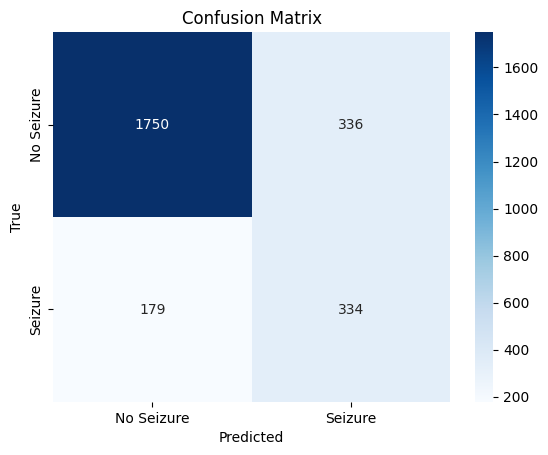

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        preds = out.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

print("\nClassification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
